# Import the packages 

In [2]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import keras
import shutil 
import matplotlib.pyplot as plt
import PIL
import scipy
import scipy.spatial
import matplotlib.cm as cm
import random

from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.layers import Input, Dense, Reshape, MaxPooling3D, Flatten, BatchNormalization, Lambda, Dropout
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Convolution3D
from keras.models import Model, Sequential
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing import image


# Check the tensorflow GPU device  

In [8]:
# %tensorflow_version 2.x

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Pre-processing steps

In [28]:
# Read all the AD, CN and MCI patient data

AD_png_files = [files for files in sorted(os.listdir(AD_trn_path)) if files.endswith('.png')]
print(len(AD_png_files))
CN_png_files = [files for files in sorted(os.listdir(CN_trn_path)) if files.endswith('.png')]
print(len(CN_png_files))
MCI_png_files = [files for files in sorted(os.listdir(MCI_trn_path)) if files.endswith('.png')]
print(len(MCI_png_files))

6840
8160
7560


In [3]:
# Stacking all the 60 slices of each subject to create the depth on z-axis and save the numpy array file
# resize the dimension to (106, 106)
# Create the new dimension- (106, 106, 60), where 60 is the depth on z-axis 

def img_array_stack_zaxis(read_path, npysavepath, classifier):
    png_files = [files for files in sorted(os.listdir(read_path)) if files.endswith('.png')]
    per_patient_name = []
    png_filename = []
    image_array_list = []
    all_stackarray_list = []

    for i in range(0, len(png_files)):
        image = Image.open(read_path+png_files[i])
        png_filename.append(png_files[i])
        newsize = (106, 106) 
        image = image.resize(newsize)
        arr_data = np.asarray(image) 
        image_array_list.append(arr_data)
        if len(image_array_list) == 60:
            dimension_zaxis = np.stack(image_array_list, axis=2)    #Create new z-axis and stacking the 60 slices on it
            all_stackarray_list.append(dimension_zaxis)
            image_array_list.clear()
            png_filename.clear()
            continue
   
    with open(npysavepath+classifier+'_img_arr.npy', 'wb') as files:
        np.save(files, np.array(all_stackarray_list))
    with open(npysavepath+classifier+'_img_arr.npy', 'rb') as files:
        image_array = np.load(files)

    return image_array
# -------------------------------------------------------------------------------------------------------------

# Funtion to augment the training data for the 60 slices at a time 
def augment_training_data(srcpath, destpath):
    datagen = ImageDataGenerator(rotation_range=10, shear_range=0.05, 
                                          width_shift_range=0.02, height_shift_range=0.02, 
                                          horizontal_flip=True, zoom_range=0.05, fill_mode="nearest")

    all_png_files = [files for files in sorted(os.listdir(srcpath)) if files.endswith('.png')]
    one_patient_files = []
       
    for file in range(0, len(all_png_files)):
        one_patient_files.append(all_png_files[file]) 
        if len(one_patient_files) == 60:
            for i in range(0, len(one_patient_files)):
                img = Image.open(srcpath+one_patient_files[i])
                x = np.asarray(img) 
                x = x.reshape((1,) + x.shape + (1,))  
                filename, file_extension = os.path.splitext(one_patient_files[i])
                aug_iter = datagen.flow(x, save_to_dir=destpath, save_prefix=filename, save_format='png')
                aug_images = [next(aug_iter)[0].astype(np.float32) for i in range(0, 1)]

                one_patient_files.clear()
            continue
# -------------------------------------------------------------------------------------------------------------
# Function to read the numpy array             
def read_numpy_arr(npysavepath, classifier):
    with open(npysavepath+classifier+'_img_arr.npy', 'rb') as files:
        image_array = np.load(files)
    return image_array

# -------------------------------------------------------------------------------------------------------------
# Function to write the numpy array
def write_numpy_arr(npy_save_pth, trn_data, classifier):
    trn_data= trn_data / 255.0                  # rescale the size between 0 and 1    
    with open(npy_save_pth+classifier+'_img_arr.npy', 'wb') as files:
        np.save(files, trn_data)

# -------------------------------------------------------------------------------------------------------------
# Function to copy the files from source and destination
def cpy_files_to_frm_rng(srcpath, dstpath, no_of_files_from, no_of_files_to):
    png_files = [files for files in sorted(os.listdir(srcpath)) if files.endswith('.png')]
    for i in range(int(no_of_files_from), int(no_of_files_to)):
        shutil.copy(srcpath+png_files[i], dstpath)
    
# -------------------------------------------------------------------------------------------------------------
# Function to Split the numpy array data into training and testing    
def split_train_test(npy_arr, split_no):
    train, test = npy_arr[:split_no,:], npy_arr[split_no:,:]
    return train, test    

# -------------------------------------------------------------------------------------------------------------
# Function to read the numpy array for train and test dataset
def numpy_trn_tst_read(npysavepath, classifier):
    with open(npysavepath+classifier+'_norm_img_arr.npy', 'rb') as files:
        image_array = np.load(files)
    return image_array

# -------------------------------------------------------------------------------------------------------------
# Function to use imagewise scaling 
def imgwise_3d_scaling(img_data):
    imgwise_scaling = True
    if imgwise_scaling:
        for n in range(len(img_data)):
            img_data[n,:,:,:] = img_data[n,:,:,:] - np.mean(img_data[n,:,:,:])
            img_data[n,:,:,:] = img_data[n,:,:,:] / np.std(img_data[n,:,:,:])
  
    return img_data    


In [ ]:
# Read all the augmented images of batch 2 dataset

nonorm_path = os.getcwd()+'/allimages/batch2/axial/'
save_npy_path = nonorm_path+'train/tentimesaug/aug_npy_array/'  # read the saved numpy array 

img_arr_AD1, img_arr_CN1, img_arr_MCI1= numpy_arr_read(save_npy_path, 'AD1'), numpy_arr_read(save_npy_path, 'CN1'), numpy_arr_read(save_npy_path, 'MCI1')


In [5]:
# Read the numpy array of training (trn_X) and target (trn_y) for 3 classes: AD, CN and MCI

import os
# nonorm_path = os.getcwd()+'/allimages/batch2/norm/'
# save_npy_path = nonorm_path+'b2_aug5times/b2_aug_npy_arr/'
# npy_norm_pth = save_npy_path+'allstack_1_5_img_npy/'

trn_X = numpy_trn_tst_read(npy_norm_pth, 'b2_trnX_3500')
trn_y = numpy_trn_tst_read(npy_norm_pth, 'b2_trny_3500')
print(trn_X.shape)
print(trn_y.shape)

(3500, 106, 106, 60, 1)
(3500, 3)


(114, 96, 96, 60, 3)


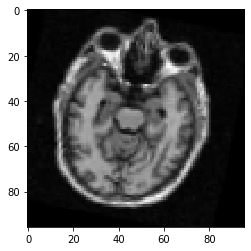

In [31]:
# Plotting done for normalized arrays- 

import matplotlib.pyplot as plt
print(img_arr_AD2.shape)
plt.imshow(img_arr_AD2[50,:,:,40],interpolation='none')

In [36]:
from keras import backend as K
K.clear_session()

In [29]:
# # from keras.backend.tensorflow_backend import set_session
# # from keras.backend.tensorflow_backend import clear_session
# # from keras.backend.tensorflow_backend import get_session
# import tensorflow as tf
# import gc

# # Reset Keras Session
# def reset_keras():
#     sess = tf.compat.v1.keras.backend.get_session()
#     tf.compat.v1.keras.backend.clear_session()
#     sess.close()
#     sess = tf.compat.v1.keras.backend.get_session()

#     try:
#         del classifier # this is from global space - change this as you need
#     except:
#         pass

#     print(gc.collect()) # if it's done something you should see a number being outputted

#     # use the same config as you used to create the session
#     config = tf.compat.v1.ConfigProto()
#     config.gpu_options.per_process_gpu_memory_fraction = 1
#     config.gpu_options.visible_device_list = "0"
#     tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

# Defined the voxcnn model

In [14]:
def voxcnn_model():
    #""" Return the Keras model of the network
    #"""
    input_shape = (106, 106, 60, 1)
    model = Sequential()
  
    # 1st Volumetric Convolutional block
    model.add(Convolution3D(8, (3, 3, 3), activation='relu', padding='same', input_shape=(106, 106, 60, 1)))
    model.add(Convolution3D(8, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization())
    # 2nd Volumetric Convolutional block
    model.add(Convolution3D(16, (3, 3, 3), activation='relu', padding='same'))
    model.add(Convolution3D(16, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization())
    # 3rd Volumetric Convolutional block
    model.add(Convolution3D(32, (3, 3, 3), activation='relu', padding='same'))
    model.add(Convolution3D(32, (3, 3, 3), activation='relu', padding='same'))
    # model.add(Convolution3D(32, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(BatchNormalization())
    # 4th Volumetric Convolutional block
    # model.add(Convolution3D(64, (3, 3, 3), activation='relu', padding='same'))
    # model.add(Convolution3D(64, (3, 3, 3), activation='relu', padding='same'))
    # model.add(Convolution3D(64, (3, 3, 3), activation='relu', padding='same'))
    # model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    # model.add(BatchNormalization())
    model.add(Flatten())
    # 1th Deconvolutional layer with batchnorm and dropout for regularization
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    # 2th Deconvolutional layer
    model.add(Dense(64, activation='relu'))
    # model.add(BatchNormalization())
    # model.add(Dropout(0.7))
    # Output with softmax nonlinearity for classification
    model.add(Dense(3, activation='softmax'))
    
    return model



In [20]:
# Model summary
model = voxcnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 106, 106, 60, 8)   224       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 106, 106, 60, 8)   1736      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 53, 53, 30, 8)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 53, 53, 30, 8)     32        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 53, 53, 30, 16)    3472      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 53, 53, 30, 16)    6928      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 26, 26, 15, 16)    0

In [51]:
# Compile the model

initial_learning_rate = 0.001
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
# )

model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate),
    metrics=["acc"]
)

# Currently working on above defined model; epoch 50, shuffle=true
epochs = 50
batch_size = 64

no_norm_path = '/data/users/dverma01/colab/'
pth = no_norm_path+"adniwith1grayscale/epochs50/"

#Define callbacks
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=25)
callbacks = [keras.callbacks.ModelCheckpoint(pth+"save_at_{epoch}.h5"), early_stopping_cb]

# Fit model
hist = model.fit(trn_X, trn_y, epochs=epochs, batch_size = batch_size, callbacks=callbacks, shuffle=True, 
                    validation_split=0.20)


Epoch 1/50
47/47 [==============================] - 49s 1s/step - loss: 1.2050 - acc: 0.4594 - val_loss: 7.3482 - val_acc: 0.0000e+00
Epoch 2/50
47/47 [==============================] - 29s 609ms/step - loss: 0.9905 - acc: 0.5718 - val_loss: 8.6309 - val_acc: 0.0000e+00
Epoch 3/50
47/47 [==============================] - 28s 605ms/step - loss: 0.8531 - acc: 0.6293 - val_loss: 0.8772 - val_acc: 0.5824
Epoch 4/50
47/47 [==============================] - 29s 607ms/step - loss: 0.7371 - acc: 0.6958 - val_loss: 2.5085 - val_acc: 0.0000e+00
Epoch 5/50
47/47 [==============================] - 28s 599ms/step - loss: 0.6463 - acc: 0.7500 - val_loss: 4.1020 - val_acc: 0.0000e+00
Epoch 6/50
47/47 [==============================] - 29s 608ms/step - loss: 0.5893 - acc: 0.7729 - val_loss: 4.1934 - val_acc: 0.0000e+00
Epoch 7/50
47/47 [==============================] - 28s 606ms/step - loss: 0.5274 - acc: 0.7892 - val_loss: 3.0243 - val_acc: 0.0838
Epoch 8/50
47/47 [==============================] - 

# Visualizing model performance

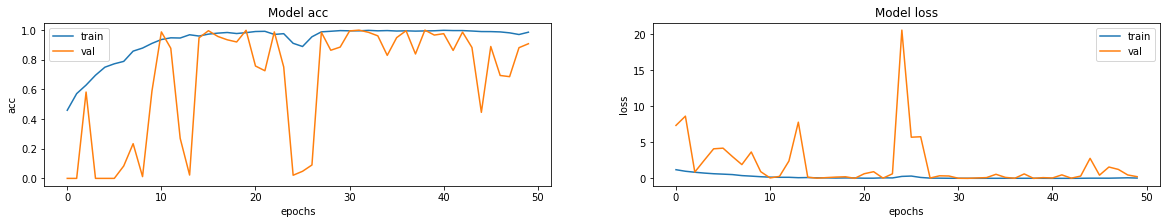

In [53]:
# Visualizing model performance--
# plot the model accuracy and plot the model loss

figure, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

# Evaluate the model

3/3 - 0s - loss: 3.9761 - acc: 0.4000


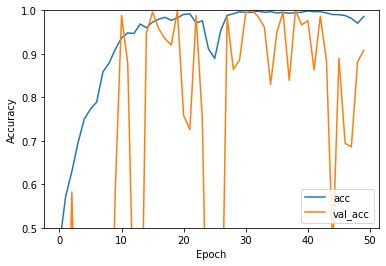

In [64]:
#Evaluate the model on unseen testing data

plt.plot(hist.history['acc'], label='acc')
plt.plot(hist.history['val_acc'], label = 'val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(tst_X,  tst_y, verbose=2)